<CENTER>
<img src="https://sdk.tradingmotion.com/Img/TMSDK.png" width="200px">

  <header>
    <h1>Herramientas python para el análisis de sistemas automáticos</h1>
    <h3>Robotrader X - 9 Marzo 2020</h3>
    <h2>victor@ibroker.es</h2>
    <p></p>
  </header>
</CENTER>

In [40]:
%matplotlib inline

#%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 300

import pandas as pd
import numpy as np

import os
import json
from datetime import datetime
import datetime 
from tqdm import tqdm
from scipy import stats
import pandas_montecarlo

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

pylab.rcParams['figure.figsize'] = (16, 6)

import seaborn as sns

sns.set_context("notebook", font_scale=1.4)
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

In [41]:
pylab.rcParams['figure.figsize'] = (16, 6)


# Contenido

- Introducción a pandas / numpy
- Dataset estrategias Tradingmotion - Exploratory Data Analysis
- Métricas de rendimiento
- ¿El sistema ha dejado de funcionar?
- Construir un ránking de sistemas
- Crear una cartera de sistemas


# Introducción a Pandas y numpy

* **numpy** - Librería fundamental para la computación científica en Python
* **pandas** - Herramienta para el análisis y manipulación de datos en Python

# Ejemplo numpy

Arrays multi-dimensional y funciones vectorizadas

In [42]:
print('Vector: ',np.arange(0.1, 1.0, 0.1))

Vector:  [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [43]:
print('Media aritmética vector: ', np.mean(np.arange(0.1, 1.0, 0.1)))

Media aritmética vector:  0.5


# Ejemplo pandas

Importación/exportación de datos. Dataframes.

In [44]:
# Cargamos un fichero CSV de internet - Datos de población procedentes del Banco Mundial
df_population = pd.read_csv("https://raw.githubusercontent.com/datasets/population/master/data/population.csv")
df_population.head(2)

,Country Name,Country Code,Year,Value
0,Arab World,ARB,1960,92490932.0
1,Arab World,ARB,1961,95044497.0


In [45]:
# Seleccionamos datos de España
df_population[df_population["Country Name"]=="Spain"].sample(5)

,Country Name,Country Code,Year,Value
12693,Spain,ESP,1961,30739250.0
12719,Spain,ESP,1987,38684815.0
12725,Spain,ESP,1993,39361262.0
12695,Spain,ESP,1963,31296651.0
12716,Spain,ESP,1984,38330364.0


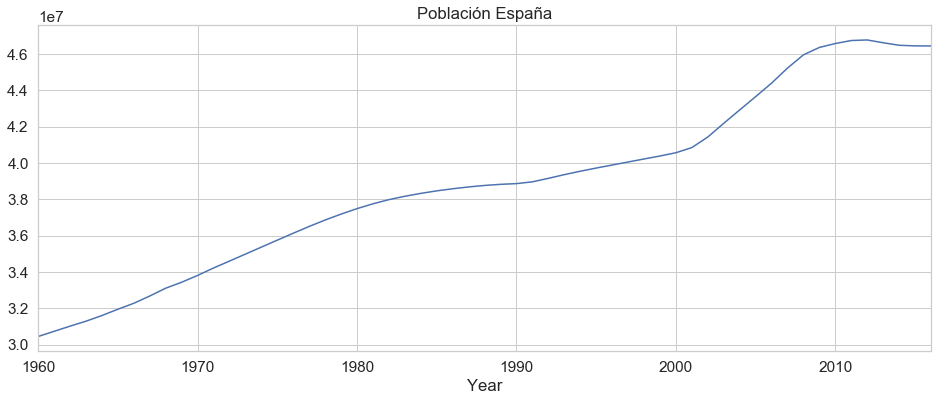

In [46]:
# Graficar evolución de la población en España
df_population[df_population["Country Name"]=="Spain"] \
    .set_index("Year")["Value"] \
    .plot(title="Población España");

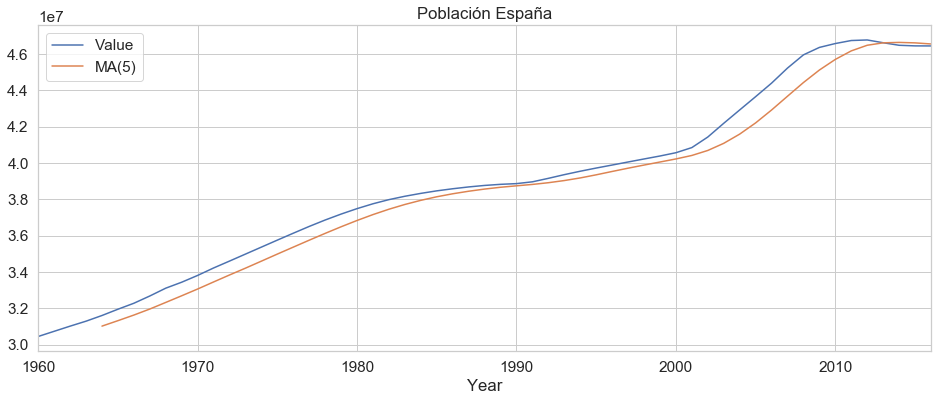

In [47]:
# Añadimos una media móvil de 5 períodos
df_spain = df_population[df_population["Country Name"]=="Spain"].set_index("Year")
df_spain["MA(5)"] = df_spain["Value"].rolling(5).mean()

df_spain.plot(title="Población España");

# Exploratory Data Analysis (EDA)


Exploramos los datos disponibles de los sistemas en tradingmotion.com

## Contenido del dataset

* **strategies.csv.gz** - Atributos genearles de los 2k+ sistemas del marketplace tradingmotion.com
* **performances.csv.gz** - Timeseries de _rendimientos_ diarios de cada sistema


## strategies.csv.gz
Cargamos el dataset con la librerías [pandas](https://pandas.org)

In [48]:
# Cargamos el CSV en un pandas DataFrame
df_strategies = pd.read_csv('data/strategies.csv.gz', 
                            compression='gzip',
                            encoding='utf-8',
                            parse_dates=["CurrentPositionTime",
                                         "FirstBackTestedDate",
                                         "FirstTradeDate",
                                         "ReleaseDate",
                                         "StatsLastUpdated"]).set_index("IdStrategyVersion")

In [49]:
# Info del dataset strategies
df_strategies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2179 entries, 12471 to 12469
Data columns (total 22 columns):
AcceptsNewClients          2179 non-null bool
CurrentPosition            2179 non-null int64
CurrentPositionTime        2179 non-null datetime64[ns, pytz.FixedOffset(120)]
FirstBackTestedDate        2179 non-null datetime64[ns]
FirstTradeDate             1124 non-null datetime64[ns]
HasClients                 2179 non-null bool
IdStrategy                 2179 non-null int64
Intraday                   2179 non-null bool
License_Currency           2179 non-null object
License_MonthlyCost        2179 non-null float64
License_nUnits             2179 non-null int64
MaxOpenPosition            2179 non-null int64
ProductID                  2179 non-null object
RecomReqCapitalCurrency    2179 non-null object
RecommendedCapital         2179 non-null float64
ReleaseDate                2179 non-null datetime64[ns]
RequiredCapital            2179 non-null float64
SlippagePerContract     

In [50]:
# Propiedades estrategia "Samurai Cooper"
# https://tradingmotion.com/explore/System/PerformanceSheet?Id=21778
df_strategies.loc[21778].to_frame()

,21778
AcceptsNewClients,True
CurrentPosition,0
CurrentPositionTime,2019-09-12 20:00:00+02:00
FirstBackTestedDate,2017-01-03 00:00:00
FirstTradeDate,2019-03-29 00:00:00
HasClients,True
IdStrategy,17649
Intraday,False
License_Currency,EUR
License_MonthlyCost,60


In [51]:
# QUERY - Sistemas Ibex con clientes que requieran menos de 2000 €
df_strategies[
    (df_strategies["HasClients"] == True) &
    (df_strategies["ProductID"] == "ES") &
    (df_strategies["RequiredCapital"] < 2000)
]

,AcceptsNewClients,CurrentPosition,CurrentPositionTime,FirstBackTestedDate,FirstTradeDate,HasClients,IdStrategy,Intraday,License_Currency,License_MonthlyCost,...,ProductID,RecomReqCapitalCurrency,RecommendedCapital,ReleaseDate,RequiredCapital,SlippagePerContract,StatsLastUpdated,StrategyVersionName,TM_Rating,systemVersionIdentifier
IdStrategyVersion,,,,,,,,,,,,,,,,,,,,,
10891,True,0,2019-09-13 03:00:00+02:00,2005-01-13,2016-02-22,True,10380,True,EUR,40.0,...,ES,EUR,20000.0,2016-01-11,1900.0,-0.134317,2019-09-12 23:15:24.240000+02:00,Steel III mini S&P,3.0,0
17173,True,0,2019-09-13 03:00:00+02:00,2002-09-04,2016-03-24,True,17104,True,EUR,40.0,...,ES,EUR,25000.0,2015-05-04,1800.0,-0.120214,2019-09-12 23:23:00.540000+02:00,Bloodhound Mini S&P,3.0,0
12477,True,0,2019-09-12 22:00:00+02:00,2008-01-02,2018-12-20,True,12291,True,EUR,115.0,...,ES,EUR,20000.0,2018-07-24,1500.0,-0.166535,2019-09-12 23:16:34+02:00,Spring ES,3.0,0
17204,True,0,2019-09-12 21:55:00+02:00,2002-01-02,2014-10-09,True,17120,True,EUR,100.0,...,ES,EUR,25000.0,2014-10-03,1500.0,-0.100827,2019-09-12 23:22:58.773000+02:00,Mini SP500 Clock,1.0,0
12138,True,0,2019-09-12 22:15:00+02:00,2006-01-10,2016-06-16,True,12113,True,EUR,170.0,...,ES,EUR,20000.0,2016-05-31,1500.0,-0.137487,2019-09-12 23:27:27.587000+02:00,BattleQuant ES,1.0,0
21766,True,0,2019-09-13 03:00:00+02:00,2016-11-01,2019-01-09,True,17594,True,EUR,105.0,...,ES,EUR,25000.0,2018-12-11,1500.0,-0.142518,2019-09-12 23:15:19.407000+02:00,ZigZag6 _ E-mini S&P ES,3.0,0
21689,True,-1,2019-09-13 03:00:00+02:00,2016-01-04,2018-10-29,True,17594,True,EUR,115.0,...,ES,EUR,35000.0,2018-10-22,1900.0,-0.121814,2019-09-13 00:05:58.557000+02:00,ZigZag 6B _ E-mini S&P ES,3.0,0
21741,True,0,2019-09-13 03:05:00+02:00,2008-02-05,2018-12-12,True,17630,True,EUR,105.0,...,ES,EUR,10000.0,2018-11-22,1500.0,-0.142764,2019-09-12 23:36:43.650000+02:00,DT Rider M1C ES v2,3.0,0
21828,True,0,2019-09-12 21:00:00+02:00,2017-01-04,2019-05-07,True,17661,True,EUR,60.0,...,ES,EUR,15000.0,2019-02-02,1500.0,-0.133276,2019-09-12 23:21:48.193000+02:00,ICARO SP,3.0,0


## performances.csv.gz
Cargamos el dataset con la librerías [pandas](https://pandas.org)

In [52]:
# Cargamos el CSV en un pandas DataFrame
df_performances = pd.read_csv(
        'data/performances.csv.gz',
        compression='gzip',
        encoding='utf-8',
        parse_dates=['TradeDate']
    ).set_index(["IdStrategyVersion", "TradeDate"]).sort_index()

In [53]:
# Campos del dataset performances
df_performances.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5505882 entries, (10007, 2001-01-02 00:00:00) to (22299, 2020-02-05 00:00:00)
Data columns (total 21 columns):
AvgRealPerformance_Curr           float64
ConsolidatedPerformance_Curr      float64
ContractSettlePrice               float64
CurrencyConversionFactor          float64
EODPosition                       int64
LicenseCostCharge                 float64
PointValue                        float64
ProductCurrency                   object
RealPerformance_Avg               float64
RealPerformance_Best              float64
RealPerformance_Worst             float64
RequestedCurrency                 object
Slippage_Real                     float64
Slippage_Theo                     float64
TheoPerformance                   float64
TheoPerformance_Curr              float64
TradingType                       object
VolumeTraded                      int64
InstitutionalLicenseCostCharge    float64
PerformanceWithNoLicenseCharge    float64
Perfor

In [54]:
# Performance estrategia "Samurai Cooper" - últimas 5 sesiones
df_performances.loc[21778].tail(5)

,AvgRealPerformance_Curr,ConsolidatedPerformance_Curr,ContractSettlePrice,CurrencyConversionFactor,EODPosition,LicenseCostCharge,PointValue,ProductCurrency,RealPerformance_Avg,RealPerformance_Best,...,RequestedCurrency,Slippage_Real,Slippage_Theo,TheoPerformance,TheoPerformance_Curr,TradingType,VolumeTraded,InstitutionalLicenseCostCharge,PerformanceWithNoLicenseCharge,PerformanceInstitutional
TradeDate,,,,,,,,,,,,,,,,,,,,,
2020-01-30,283.3439,283.3439,2.549,0.906701,-1,0.0,25000.0,USD,0.0125,0.0125,...,EUR,0.000000,0.0,0.0125,283.3439,R,0,1.363636,283.3439,281.980264
2020-01-31,836.9526,836.9526,2.512,0.904814,-1,0.0,25000.0,USD,0.0370,0.0370,...,EUR,0.000000,0.0,0.0370,836.9526,R,0,1.363636,836.9526,835.588964
2020-02-03,-309.5970,-379.5373,2.507,0.903669,0,-60.0,25000.0,USD,-0.0137,-0.0135,...,EUR,-0.000204,0.0,-0.0135,-304.9883,R,1,1.500000,-319.5373,-321.037300
2020-02-04,196.3930,126.4365,2.545,0.905141,-1,-60.0,25000.0,USD,0.0087,0.0100,...,EUR,-0.001321,0.0,0.0100,226.2853,R,1,1.500000,186.4365,184.936500
2020-02-05,-907.1940,-907.1940,2.585,0.907194,-1,0.0,25000.0,USD,-0.0400,-0.0400,...,EUR,0.000000,0.0,-0.0400,-907.1940,R,0,1.500000,-907.1940,-908.694000


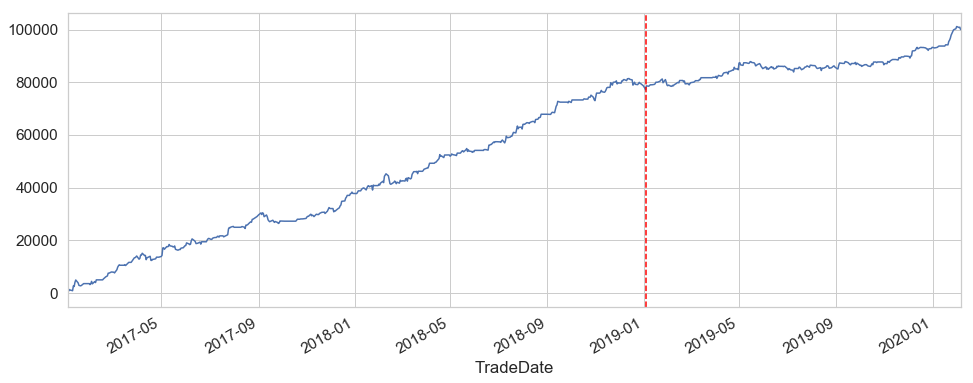

In [55]:
# Performance estrategia "Samurai Cooper" - gráfico
plot = df_performances.loc[21778]["ConsolidatedPerformance_Curr"].cumsum().plot();
# Marcamos la fecha de "verificación"
plot.axvline(df_strategies.loc[21778]["ReleaseDate"], color="red", linestyle="--");

# Distribución de retornos diarios

Asumiendo una distribución normal, según regla empírica (regla 68-95-99.7):

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/Empirical_rule_histogram.svg/450px-Empirical_rule_histogram.svg.png"/>

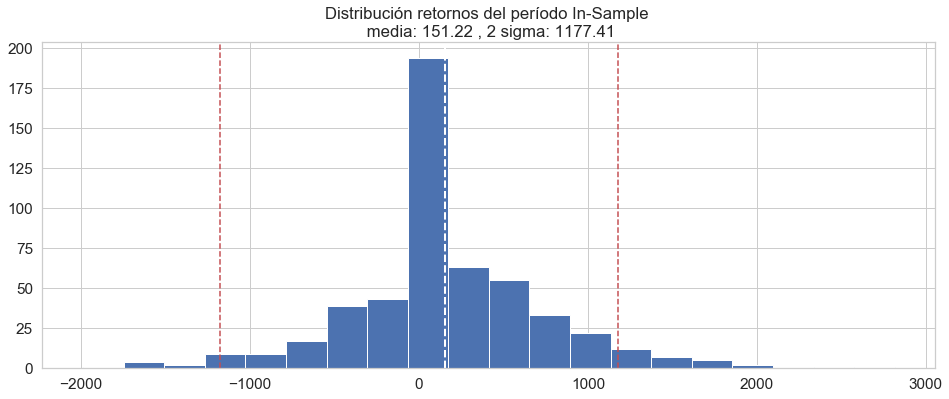

In [56]:
# Histograma de retornos diarios del período In-sample
df_rtn = df_performances.loc[21778]["ConsolidatedPerformance_Curr"]
df_rtn_insample = df_rtn[:df_strategies.loc[21778]["ReleaseDate"]]

df_rtn_insample.hist(bins=20)
plt.axvline(df_rtn_insample.mean().item(), color='w', linestyle='--', linewidth=2)
plt.axvline(2*df_rtn_insample.std().item(), color='r', linestyle='--')
plt.axvline(-2*df_rtn_insample.std().item(), color='r', linestyle='--')
plt.title("Distribución retornos del período In-Sample \n media: {:.2f} , 2 sigma: {:.2f}".format(
          df_rtn_insample.mean().item(), \
          2*df_rtn_insample.std().item()))
plt.show()

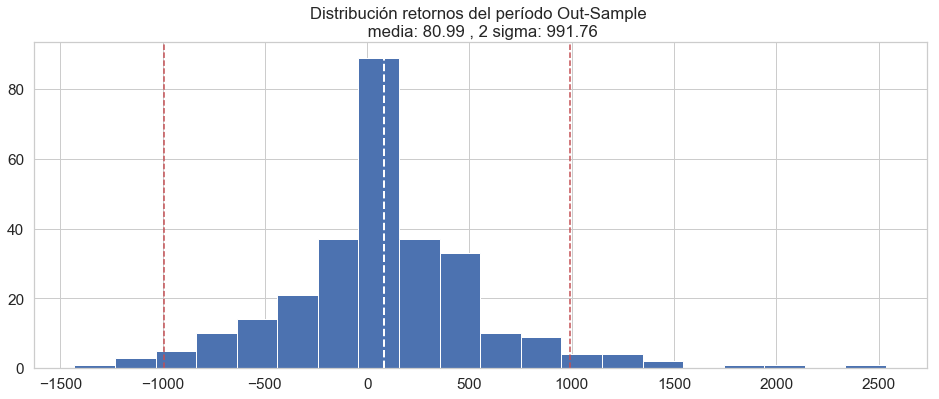

In [57]:
# Histograma de retornos diarios del período Out-sample
df_rtn_outsample = df_rtn[df_strategies.loc[21778]["ReleaseDate"]:]


df_rtn_outsample.hist(bins=20)
plt.axvline(df_rtn_outsample.mean().item(), color='w', linestyle='--', linewidth=2)
plt.axvline(2*df_rtn_outsample.std().item(), color='r', linestyle='--')
plt.axvline(-2*df_rtn_outsample.std().item(), color='r', linestyle='--')
plt.title("Distribución retornos del período Out-Sample \n media: {:.2f} , 2 sigma: {:.2f}".format(
          df_rtn_outsample.mean().item(), \
          2*df_rtn_outsample.std().item()))
plt.show()

# Performance Metrics - quantstats

quantstats calcula las métricas a partir del porcentaje de retornos diarios

                           Strategy
-------------------------  ----------
Start Period               2017-01-03
End Period                 2020-02-05
Risk-Free Rate             0.0%
Time in Market             78.0%

Cumulative Return          506.9%
CAGR%                      79.23%
Sharpe                     3.25
Sortino                    6.39
Max Drawdown               -8.91%
Longest DD Days            172
Volatility (ann.)          17.99%
Calmar                     8.89
Skew                       1.88
Kurtosis                   14.89

Expected Daily %           0.23%
Expected Monthly %         4.86%
Expected Yearly %          56.96%
Kelly Criterion            32.7%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.63%
Expected Shortfall (cVaR)  -1.63%

Payoff Ratio               1.35
Profit Factor              2.14
Common Sense Ratio         3.56
CPC Index                  1.78
Tail Ratio                 1.66
Outlier Win Ratio          6.45
Outlier Loss Ratio         3.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2017-01-16,2017-01-19,2017-02-08,23,-8.907213,-8.531231
2,2017-09-07,2017-09-26,2017-11-20,74,-8.016991,-7.679322
3,2017-04-10,2017-04-19,2017-05-03,23,-7.776540,-7.710101
4,2018-02-12,2018-02-15,2018-03-15,31,-6.088915,-5.858345
5,2017-05-12,2017-05-22,2017-06-02,21,-5.602729,-5.370560


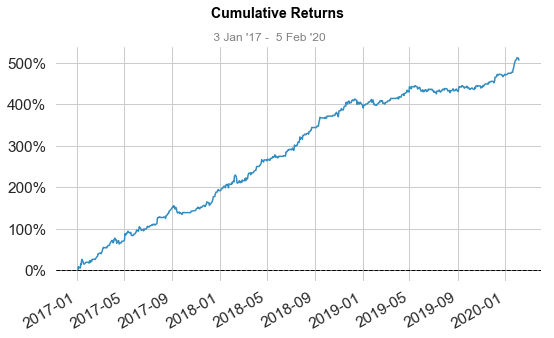

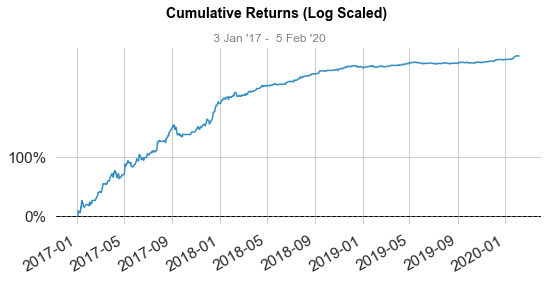

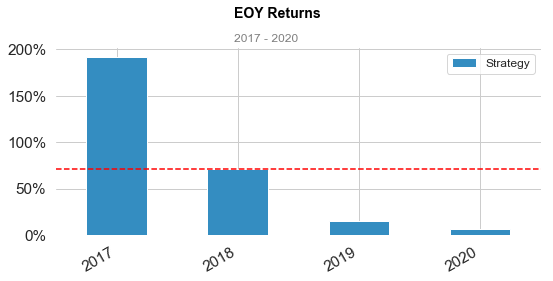

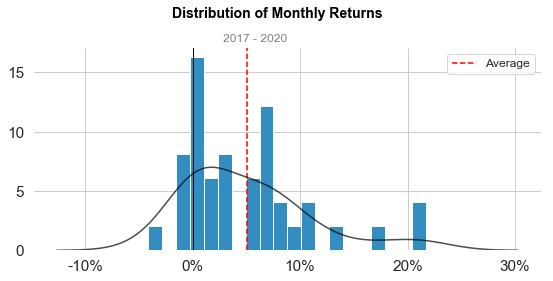

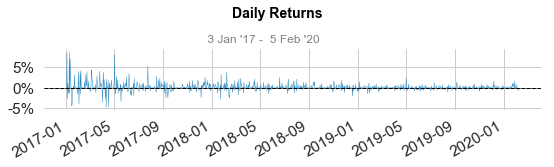

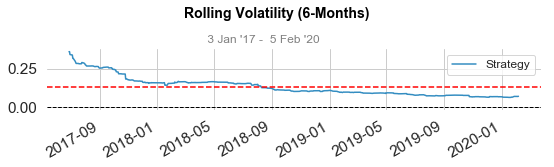

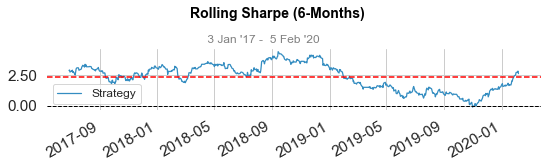

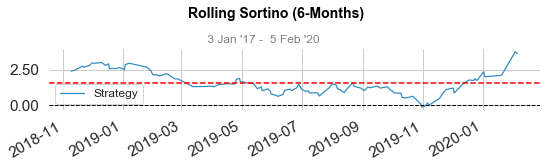

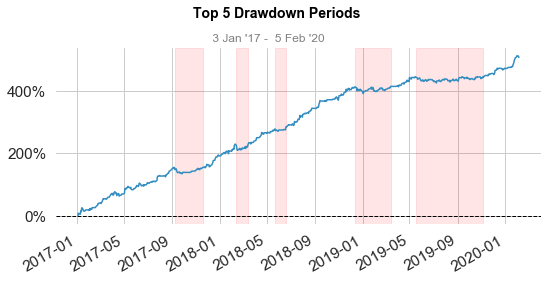

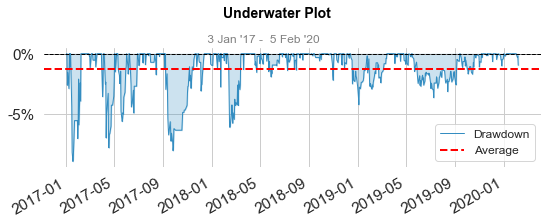

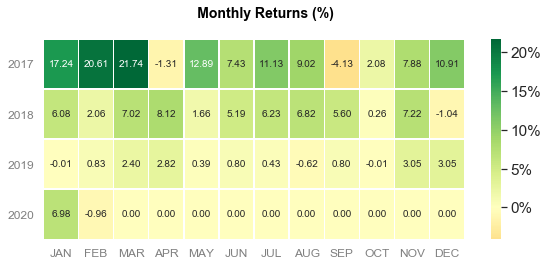

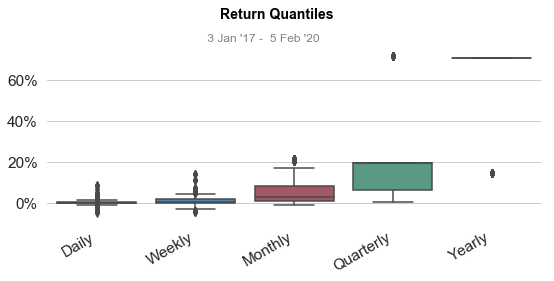

In [58]:
import quantstats as qs

# Calculamos porcentaje de retornos absolutos, tomando el "Capital Recomendado"
# como saldo inicial de la cuenta
df_rtn_capital = df_rtn
df_rtn_capital[0] = df_rtn_capital[0] + df_strategies.loc[21778]["RecommendedCapital"]
df_rtn_capital_percentage = df_rtn_capital.cumsum().pct_change().fillna(0)

qs.reports.full(df_rtn_capital_percentage)

# Performance Metrics - pyfolio

pyfolio calcula las métricas a partir del porcentaje de retornos diarios

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.91,2017-01-13,2017-01-19,2017-02-08,19
1,8.02,2017-09-06,2017-09-26,2017-11-20,54
2,7.78,2017-04-07,2017-04-19,2017-05-03,19
3,6.09,2018-02-09,2018-02-15,2018-03-15,25
4,5.60,2017-05-11,2017-05-22,2017-06-02,17


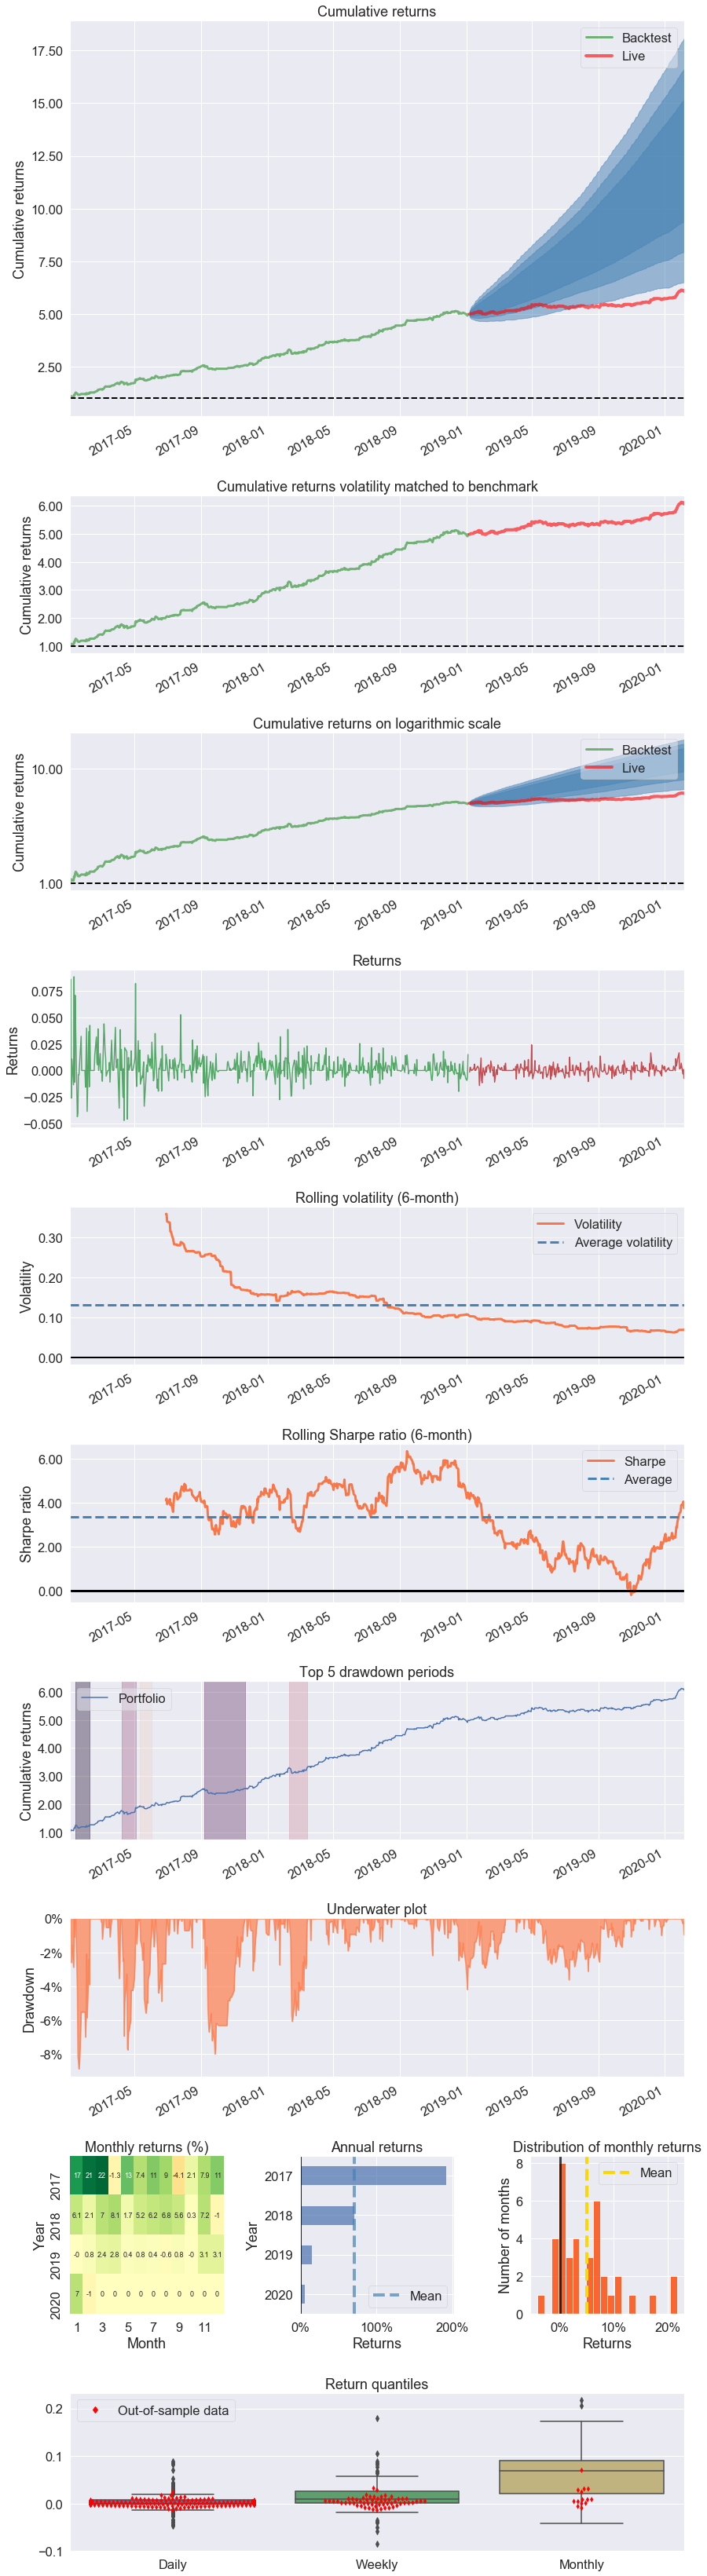

In [59]:
import pyfolio as pf

df_rtn_capital_percentage.index = pd.to_datetime(df_rtn_capital_percentage.index).tz_localize('Europe/Madrid')

pf.create_returns_tear_sheet(df_rtn_capital_percentage, \
                             live_start_date=df_strategies.loc[21778]["ReleaseDate"])


# pyfolio - paquete empyrical

Common financial risk and performance metrics

In [60]:
df_rtn_capital_percentage_IS = df_rtn_capital_percentage[:df_strategies.loc[21778]["ReleaseDate"]]
df_rtn_capital_percentage_OS = df_rtn_capital_percentage[df_strategies.loc[21778]["ReleaseDate"]:]

In [61]:
import empyrical 

print("Max Drawdown - IS={:.2f} OS={:.2f}".format( \
                                                  empyrical.max_drawdown(df_rtn_capital_percentage_IS), \
                                                  empyrical.max_drawdown(df_rtn_capital_percentage_OS)))
print("Calmar ratio: {:.2f}".format(empyrical.calmar_ratio(df_rtn_capital_percentage)))
print("Sortino ratio: {:.2f}".format(empyrical.sortino_ratio(df_rtn_capital_percentage)))



Max Drawdown - IS=-0.09 OS=-0.04
Calmar ratio: 8.57
Sortino ratio: 6.39


In [62]:
pylab.rcParams['figure.figsize'] = (16, 6)

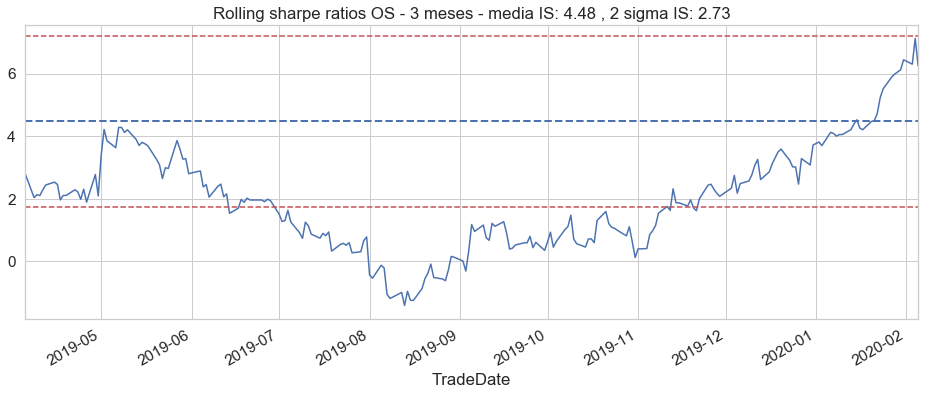

In [63]:
# Cálculo de rolling Sharpe Ratios del período Out-Sample
# Lo comparamos con la distrubición de Sharpe Ratios del período In-Sample
df_roll_sharpe_ratio_IS = empyrical.roll_sharpe_ratio(df_rtn_capital_percentage_IS, window=22*3)
df_roll_sharpe_ratio_OS = empyrical.roll_sharpe_ratio(df_rtn_capital_percentage_OS, window=22*3)

df_roll_sharpe_ratio_OS.plot();
plt.axhline(df_roll_sharpe_ratio_IS.mean().item(), color='b', linestyle='--', linewidth=2)
plt.axhline(df_roll_sharpe_ratio_IS.mean().item()+(2*df_roll_sharpe_ratio_IS.std().item()), color='r', linestyle='--')
plt.axhline(df_roll_sharpe_ratio_IS.mean().item()-(2*df_roll_sharpe_ratio_IS.std().item()), color='r', linestyle='--')
plt.title("Rolling sharpe ratios OS - 3 meses - media IS: {:.2f} , 2 sigma IS: {:.2f}".format(
          df_roll_sharpe_ratio_IS.mean().item(), \
          2*df_roll_sharpe_ratio_IS.std().item()))
plt.show();

# Análisis bayesiano - pyfolio

pyfolio tiene herramientas para la **cuantificación de incertidumbre**

Los "_performance metrics_" tradicionales (como el Sharpe Ratio) son simples valores concretos. Éstos incluyen ruido, puesto que se han calculado a partir de un conjunto de datos limitado.

**¿Cuánto podemos confiar en estas métricas?** No lo podemos saber, puesto que no tenemos en cuenta el concepto de incertidumbre.

## Estadística Bayesiana

En vez de tratar con valores concretos, tratamos con distribuciones de probabilidad que asignan grados de confianza a todos los posibles valores de cada métrica.

El análisis bayesiano tarda bastante, lo comentamos
Running T model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two_log__, volatility_log__, mean returns]
Could not pickle model, sampling singlethreaded.
Sequential sampling (4 chains in 1 job)
NUTS: [nu_minus_two_log__, volatility_log__, mean returns]
  0%|          | 0/2500 [00:00<?, ?it/s]Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/victor/.virtualenvs/robotrader/lib/python3.6/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/victor/.virtualenvs/robotrader/lib/python3.6/site-packages/joblib/externals/loky/backend/reduction.py", line 247, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/victor/.virtualenvs/robotrader/lib/python3.6/site-packages/joblib/externals/loky/backend/reduction.py", line 240, in dump
    _LokyPickler(file, reducers=reducers, protocol=p

100%|██████████| 2500/2500 [00:03<00:00, 645.25it/s]
The acceptance probability does not match the target. It is 0.8940714860391474, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.932621328084587, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9512948949884139, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9364569155182783, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 2000/2000 [00:00<00:00, 2138.60it/s]



Finished T model (required 34.66 seconds).

Running BEST model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two_log__, group2_std_interval__, group1_std_interval__, group2_mean, group1_mean]
Could not pickle model, sampling singlethreaded.
Sequential sampling (4 chains in 1 job)
NUTS: [nu_minus_two_log__, group2_std_interval__, group1_std_interval__, group2_mean, group1_mean]
  0%|          | 0/2500 [00:00<?, ?it/s]Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/victor/.virtualenvs/robotrader/lib/python3.6/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/victor/.virtualenvs/robotrader/lib/python3.6/site-packages/joblib/externals/loky/backend/reduction.py", line 247, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/victor/.virtualenvs/robotrader/lib/python3.6/site-packages/joblib/externals/loky/backend/reduc

100%|██████████| 2500/2500 [00:30<00:00, 83.31it/s] 
The acceptance probability does not match the target. It is 0.884457004547085, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9346671414388393, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9549857173133909, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9649630606999353, but should be close to 0.8. Try to increase the number of tuning steps.



Finished BEST model (required 92.91 seconds).


No handles with labels found to put in legend.



Finished plotting BEST results (required 1.21 seconds).

Finished computing Bayesian predictions (required 0.14 seconds).

Finished plotting Bayesian VaRs estimate (required 0.12 seconds).

Total runtime was 129.04 seconds.


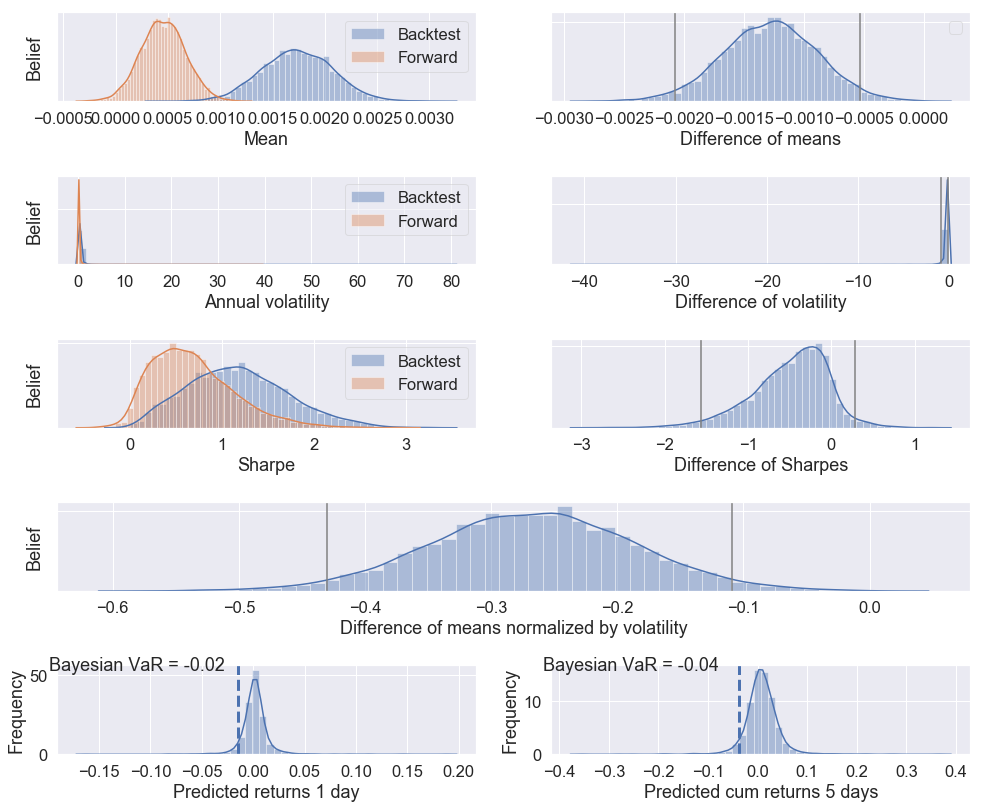

In [64]:
#print ("El análisis bayesiano tarda bastante, lo comentamos")
pf.create_bayesian_tear_sheet(df_rtn_capital_percentage, \
                             live_start_date=df_strategies.loc[21778]["ReleaseDate"])

# ¿El sistema ha dejado de funcionar?

## Prueba t de Student

https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/t-test/

El T-test nos cuenta como de distintos son 2 conjuntos de datos. Podemos aplicarlo a sistemas de trading tomando como "grupo de control" el backtest (in-sample) 

De este modo podemos medir "como de distintos" son los resultados out-sample de los resultados esperados (in-sample). 

El resultado del test contiene 2 valores: 

* t-statistic (o t-score): Cuánto más bajo el valor, más probable que las distribuciones sean iguales (tengan la misma media)
* p-value: Confiabilidad del test. Asumimos que el test es correcto si p-value < 5%

Si el t-statistic es alto, probablemente el sistema haya dejado de funcionar

In [65]:
# Hacemos el análisis T-Test comparando los período In-Sample y Out-Sample
res = stats.ttest_ind(df_rtn_capital_percentage_IS, df_rtn_capital_percentage_OS)
t_statistic = res[0]
p_value = res[1]/2

print("""
T-Test results:
 t-statistic:        {:.3f}
 p-value:        {:.3f}%
""".format(t_statistic, p_value*100))


T-Test results:
 t-statistic:        2.908
 p-value:        0.187%



In [66]:
# Calculamos la serie temporal Rolling t-test (periodo de 30 sesiones)
roll_ttest = []

for date in tqdm(df_rtn_capital_percentage.index):
    res = stats.ttest_ind(df_rtn_capital_percentage_IS, df_rtn_capital_percentage[:date].tail(3*30))
    
    t_statistic = res[0]
    p_value = res[1]/2
    roll_ttest.append([date, t_statistic, p_value])


100%|██████████| 801/801 [00:00<00:00, 847.99it/s]


In [67]:
df_roll_ttest = pd.DataFrame(roll_ttest, columns = ["TradeDate","T-Statistic", "P-Value"]) \
    .set_index("TradeDate").dropna()

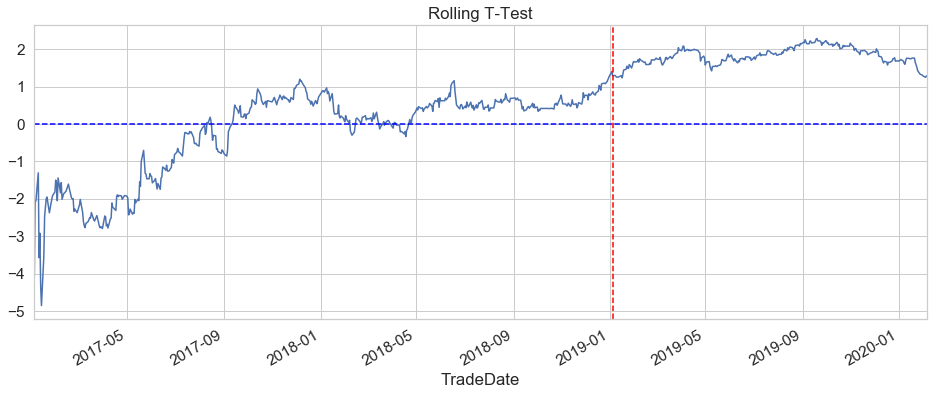

In [68]:
plot = df_roll_ttest["T-Statistic"].plot();

plot.axvline(df_strategies.loc[21778]["ReleaseDate"], color="red", linestyle="--");
plot.axhline(0, color="blue", linestyle="--");
plt.title("Rolling T-Test")
plt.show();

# Ranking de sistemas por T-Statistic

Construir un ránking de sistemas:

* Excluimos sistemas con menos de 2 años de período verificado
* Ejecutamos un T-Test para determinar cómo de parecida es la distribución de retornos IS (periodo auditado hasta hace 6 meses) con la distribución de retornos OS (de hace 6 hasta 3 meses)
* Calculamos el Sharpe Ratio de ambos períodos
* Ordenamos la tabla resultante por el campo `Sharpe Ratio IS` 

In [69]:
# Construir ranking
ttest_rank = []

a_year_ago = '2019-01-01'
two_years_ago = '2018-01-01'
three_months_ago = '2019-11-01'
six_months_ago = '2019-08-01'


for IdStrategyVersion in tqdm(df_strategies[df_strategies["ReleaseDate"] < two_years_ago].index):
    
    df_dailyrets_capital = df_performances.loc[IdStrategyVersion]["ConsolidatedPerformance_Curr"]
    df_dailyrets_capital[0] = df_dailyrets_capital[0] + df_strategies.loc[IdStrategyVersion]["RecommendedCapital"]
    df_dailyrets_capital_percentage = df_dailyrets_capital.cumsum().pct_change().fillna(0)
    
    df_dailyrets_IS = df_dailyrets_capital_percentage[df_strategies.loc[IdStrategyVersion]["ReleaseDate"]:six_months_ago]
    df_dailyrets_three_to_six_months = df_dailyrets_capital_percentage[six_months_ago:three_months_ago]
    
    res = stats.ttest_ind(df_dailyrets_IS, df_dailyrets_three_to_six_months)
    
    t_statistic = res[0]
    p_value = res[1]/2
    sharpe_ratio_is = empyrical.sharpe_ratio(df_dailyrets_IS)
    sharpe_ratio_three_to_six_months = empyrical.sharpe_ratio(df_dailyrets_three_to_six_months)
    
    ttest_rank.append([IdStrategyVersion, t_statistic, p_value, sharpe_ratio_is, sharpe_ratio_three_to_six_months])
    

100%|██████████| 1195/1195 [00:08<00:00, 137.76it/s]


In [70]:
# Visualizamos el ranking
df_ttest_rank = pd.DataFrame(ttest_rank, \
                             columns = ["IdStrategyVersion", \
                                        "T-Statistic", \
                                        "P-Value", \
                                        "Sharpe Ratio IS", \
                                        "Sharpe Ratio 3 to 6 months ago"] \
                            ).set_index("IdStrategyVersion").sort_values(by="Sharpe Ratio IS", ascending=False)

df_ttest_rank

,T-Statistic,P-Value,Sharpe Ratio IS,Sharpe Ratio 3 to 6 months ago
IdStrategyVersion,,,,
17654,0.644509,0.259733,1.863760,0.370720
17519,0.503908,0.307235,1.828912,0.557791
17923,0.876944,0.190442,1.491685,-0.402935
17653,1.822926,0.034380,1.474845,-1.891281
21147,-0.308202,0.379032,1.377091,2.200628
...,...,...,...,...
17715,1.750042,0.040299,-2.466240,-6.656987
17795,-0.340126,0.366940,-2.766988,-1.906043
17577,3.190150,0.000742,-3.535349,-2.280476


# Creación de cartera de sistemas

A partir del ránking generado en la sección anterior, crearemos una cartera de sistemas y analizamos su rendimiento en los 3 últimos meses que hemos dejado fuera de la muestra.

Criterio de selección de sistemas para el portfolio:

* El valor de `T-Statistic` está entre 0 y 2
* El valor de `P-Value` está por debajo de 0.5
* El `Sharpe Ratio IS` está por encima de 1
* El `Sharpe Ratio 3 to 6 months ago` (3 últimos meses de la muestra) está por encima de 0

In [71]:
# Query - Filtrar sistemas del ranking para construir nuestra cartera de sistemas
df_portfolio_ttest = df_ttest_rank[ \
              (np.abs(df_ttest_rank["T-Statistic"]) > 0) & (np.abs(df_ttest_rank["T-Statistic"]) < 2) & \
              (df_ttest_rank["P-Value"] < 0.5) & \
              (df_ttest_rank["Sharpe Ratio IS"] > 1) & \
              (df_ttest_rank["Sharpe Ratio 3 to 6 months ago"] > 0)
             ]

df_portfolio_ttest

,T-Statistic,P-Value,Sharpe Ratio IS,Sharpe Ratio 3 to 6 months ago
IdStrategyVersion,,,,
17654,0.644509,0.259733,1.863760,0.370720
17519,0.503908,0.307235,1.828912,0.557791
21147,-0.308202,0.379032,1.377091,2.200628
17986,0.229869,0.409140,1.304978,0.880336
12373,-0.204221,0.419127,1.212034,1.545206
12296,0.575806,0.282480,1.168432,0.216974
17765,0.176542,0.429964,1.124123,0.843295
21050,0.124268,0.450576,1.123915,1.088572
17893,-0.995876,0.159865,1.035835,3.458037


In [72]:
# Alineamos los retornos diarios de los sistemas seleccionados en el portfolio
df_systems_portfolio = df_performances.loc[df_portfolio_ttest.index][["ConsolidatedPerformance_Curr"]] \
    .unstack(level=0).fillna(0).sort_index()[two_years_ago:]
df_systems_portfolio.columns = df_systems_portfolio.columns.droplevel()

df_systems_portfolio[three_months_ago:]

IdStrategyVersion,12296,12373,17519,17654,17765,17893,17986,21050,21147
TradeDate,,,,,,,,,
2019-11-01,-60.0000,-50.0000,-95.0000,1184.4017,-460.0,1225.0,7.6305,-660.0,1224.2890
2019-11-04,-60.0000,-50.0000,0.0000,571.3389,-840.0,-140.0,-30.0000,-850.0,500.6551
2019-11-05,0.0000,0.0000,0.0000,-202.5385,-115.0,-325.0,0.0000,-80.0,135.0257
2019-11-06,0.0000,0.0000,0.0000,247.9711,-105.0,75.0,0.0000,100.0,117.2227
2019-11-07,0.0000,0.0000,0.0000,406.2472,-480.0,-1615.0,-456.8024,-460.0,1078.8120
...,...,...,...,...,...,...,...,...,...
2020-01-30,2063.5315,360.8668,0.0000,1065.3731,325.0,1875.0,-1034.0416,-830.0,598.4223
2020-01-31,5025.8260,-12.3055,-281.2678,-3042.4358,1625.0,3335.0,-1571.6612,-1260.0,-2723.4890
2020-02-03,-60.0000,1440.6922,-343.7671,763.3020,-635.0,-1375.0,-30.0000,630.0,582.0866


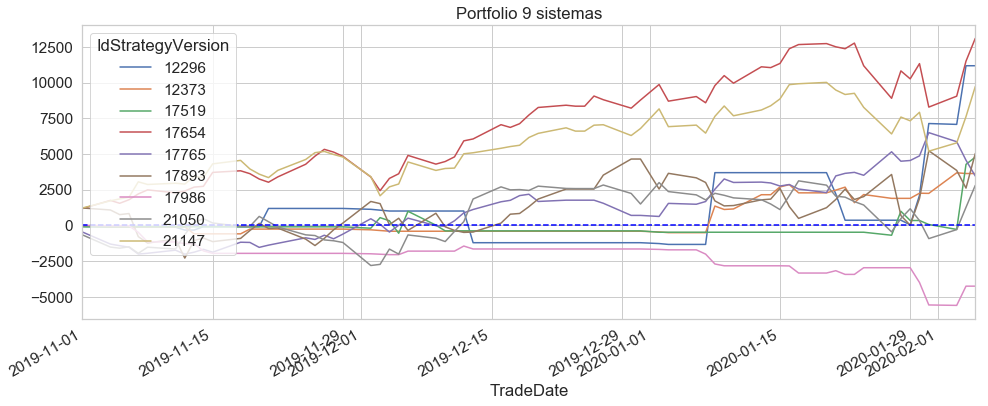

In [73]:
# Gráfico equity de los sistemas incluídos en nuestra cartera (3 meses fuera de muestra)
plot = df_systems_portfolio[three_months_ago:].cumsum().plot();
plot.axhline(0, color="blue", linestyle="--");
plt.title("Portfolio {} sistemas".format(len(df_portfolio_ttest)))
plt.show();

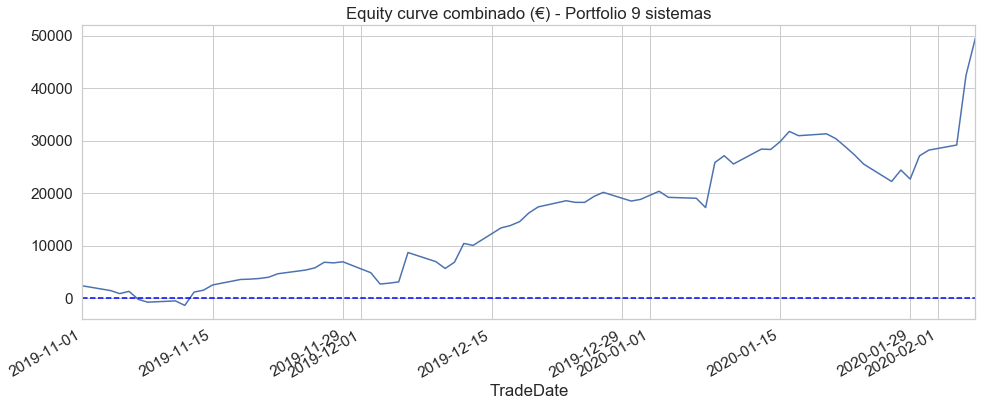

In [74]:
# Gráfico equity combinado de la cartera (3 meses fuera de muestra)
plot = df_systems_portfolio.sum(axis=1)[three_months_ago:].cumsum().plot();
plot.axhline(0, color="blue", linestyle="--");
plt.title("Equity curve combinado (€) - Portfolio {} sistemas".format(len(df_portfolio_ttest)))
plt.show();

# Análisis de Montecarlo 

Vamos a realizar un análisis de Montecarlo para determinar el Capital Sugerido de la cartera. 

Un criterio común es tomar 3 veces el peor drawdown visto en la simulación Montecarlo

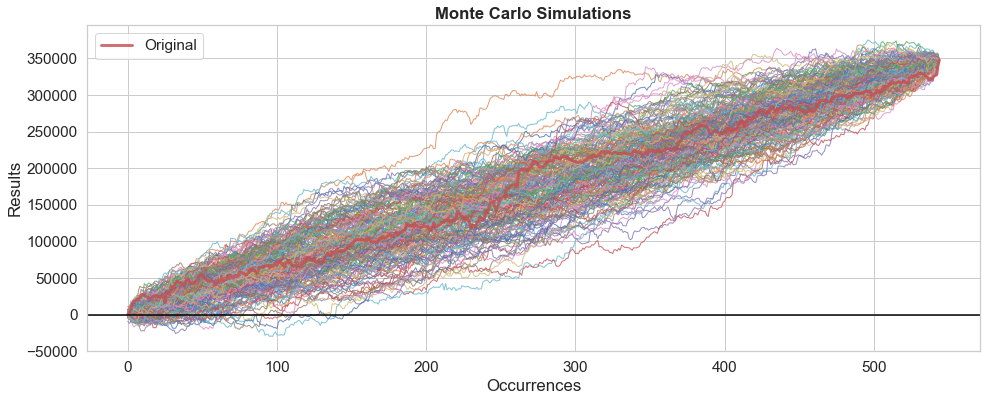

In [75]:
# Simulación montecarlo para determinar Capital Sugerido (3 veces peor drawdown)
mc = df_systems_portfolio.sum(axis=1).montecarlo(sims=200)
mc.plot(title="Monte Carlo Simulations")

In [76]:
# Cálculo del Capital Recomendado
portfolio_capital_recomendado = -3*mc.maxdd["min"]
print("Capital Recomendado para operar portfolio: {:.0f}€".format(portfolio_capital_recomendado))

Capital Recomendado para operar portfolio: 89641€


In [77]:
# Métricas de la simulación montecarlo
print("Montecarlo Stats {}", json.dumps(mc.stats, indent=2))
print("Montecarlo Max Drawdowns {}", json.dumps(mc.maxdd, indent=2))

Montecarlo Stats {} {
  "min": 347731.7170999993,
  "max": 347731.71710000065,
  "mean": 347731.7171,
  "median": 347731.7171,
  "std": 2.1172836253065154e-10,
  "maxdd": -29880.356000000007,
  "bust": 0.76,
  "goal": 0.24
}
Montecarlo Max Drawdowns {} {
  "min": -29880.356000000007,
  "max": -5.782199999997829,
  "mean": -5926.893788157895,
  "median": -4380.41075,
  "std": 5688.177135563851
}


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.52,2018-03-09,2018-03-23,2018-04-17,28
1,10.47,2018-11-07,2018-11-20,2018-12-04,20
2,9.81,2018-01-15,2018-02-05,2018-02-06,17
3,5.96,2018-05-24,2018-05-29,2018-06-19,19
4,5.20,2018-12-11,2018-12-13,2018-12-18,6


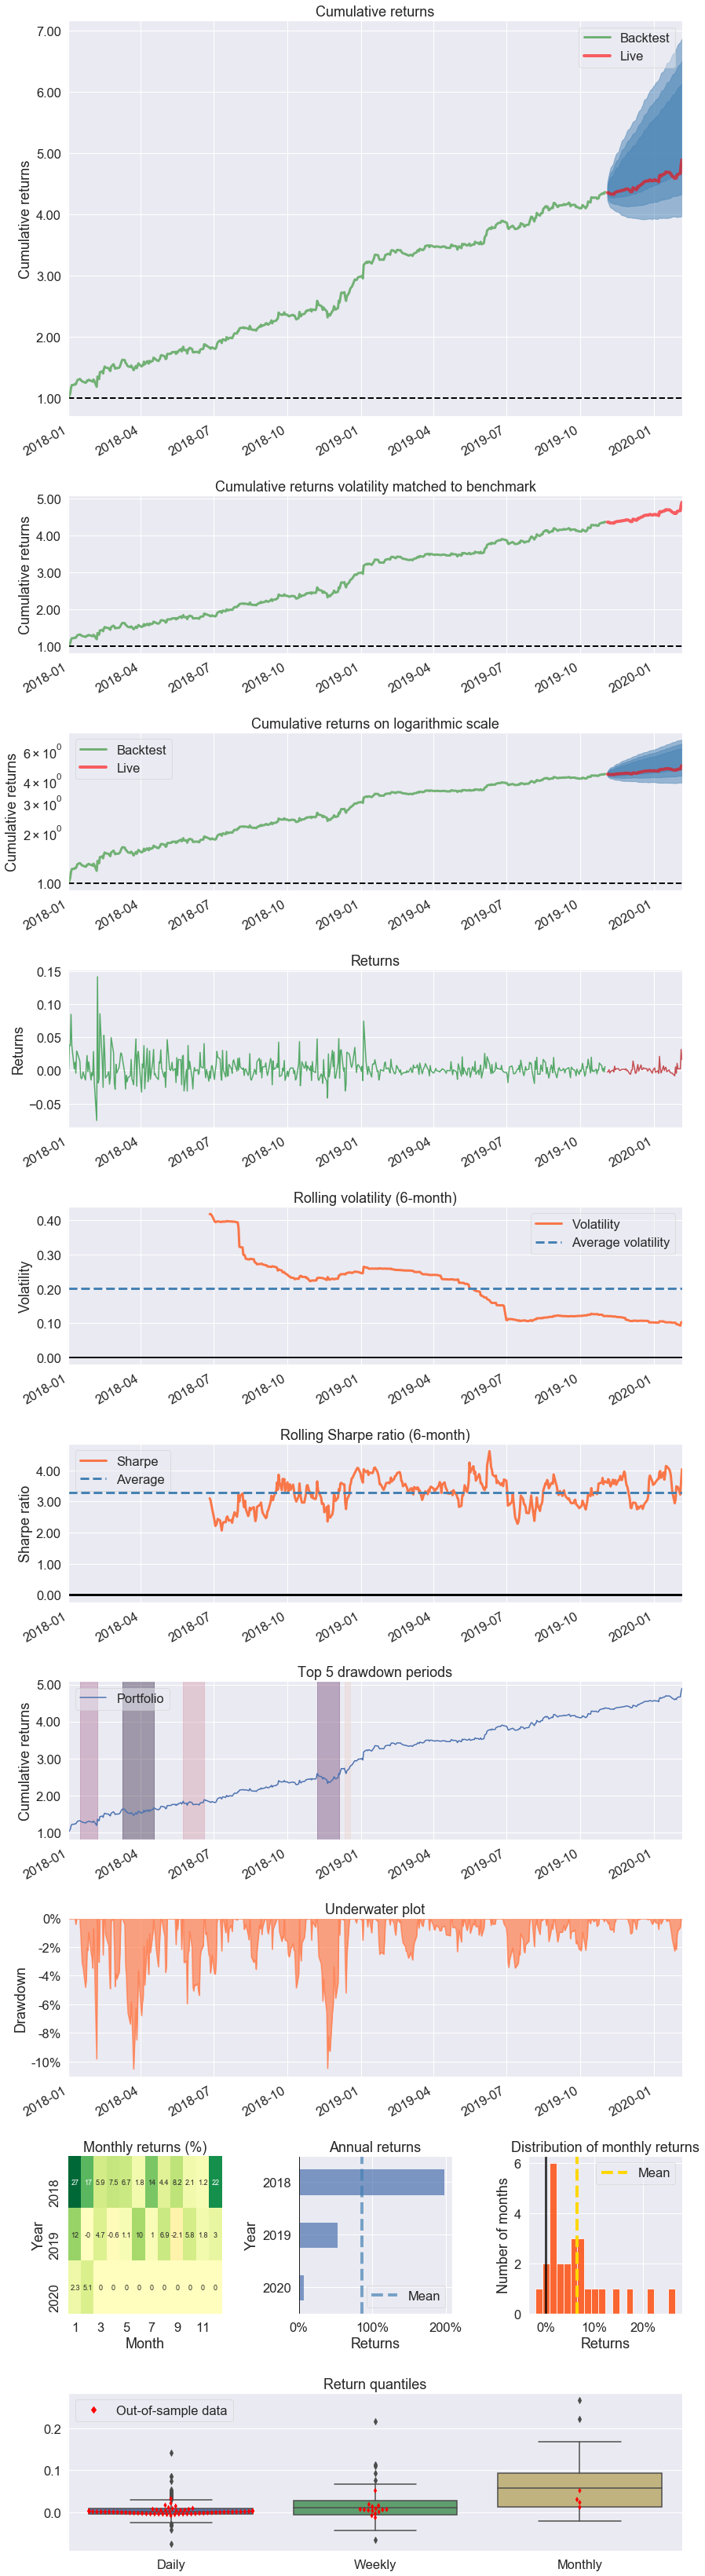

In [78]:
# Generamos el informe de rendimiento de la cartera usando pyfolio
df_rtn_capital = df_systems_portfolio.sum(axis=1)
df_rtn_capital[0] = df_rtn_capital[0] + portfolio_capital_recomendado
df_rtn_capital_percentage = df_rtn_capital.cumsum().pct_change().fillna(0)

df_rtn_capital_percentage.index = pd.to_datetime(df_rtn_capital_percentage.index).tz_localize('Europe/Madrid')

pf.create_returns_tear_sheet(df_rtn_capital_percentage,
                                live_start_date=three_months_ago)

<CENTER>
<img src="https://media.giphy.com/media/xUPGcg1IJEKGCI6r5e/giphy.gif" width="80%">

  <header>
    <h1>¿Preguntas?</h1>
    <h2>victor@ibroker.es</h2>
    <p></p>
  </header>
</CENTER>